In [1]:
from matminer.featurizers.composition import alloy
from matminer.featurizers.conversions import StrToComposition

import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data.csv')

# Convert formula to composition
data = StrToComposition().featurize_dataframe(data, 'formula')
# 然后基于composition计算特征
data = alloy.WenAlloys().featurize_dataframe(data, 'composition')

StrToComposition:   0%|          | 0/799 [00:00<?, ?it/s]

WenAlloys:   0%|          | 0/799 [00:00<?, ?it/s]

In [20]:
# 去除数据中的'formula', 'C11', 'C12', 'C44', 'a', 'b', 'c', 'G', 'B', 'E', 'v', 'Zener', 'composition', 'Weight Fraction', 'Atomic Fraction'
# data.drop(['formula', 'composition', 'Weight Fraction', 'Atomic Fraction'], axis=1, inplace=True)
# data.drop(['Interant electrons', 'Interant s electrons', 'Interant p electrons', 'Interant d electrons', 'Interant f electrons'], axis=1, inplace=True)

# data.dropna(axis=1, how='any', inplace=True)

# 选择前1500条数据作为训练集和验证集；后500条数据作为验证集。
data_fit = data.iloc[:400]
data_test = data.iloc[400:]

In [21]:
data_fit_X = data_fit[['APE mean', 'Electronegativity local mismatch', 'VEC mean', 'Shear modulus mean', 'Shear modulus delta', 'Shear modulus strength model']]
data_fit_y = data_fit['SFE']
data_test_X = data_test[['APE mean', 'Electronegativity local mismatch', 'VEC mean', 'Shear modulus mean', 'Shear modulus delta', 'Shear modulus strength model']]
data_test_y = data_test['SFE']

In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

model_gbr = GradientBoostingRegressor()
param_grid_simple = {'n_estimators': list(range(100, 1000, 100)), 'max_depth': list(range(1, 10, 1)), 'learning_rate': [0.1, 0.01, 0.001], 'loss': ['squared_error', 'absolute_error', 'huber', 'quantile']}
search_gbr = GridSearchCV(estimator=model_gbr, param_grid=param_grid_simple, cv=5, scoring='neg_mean_squared_error', n_jobs=5)
search_gbr.fit(data_fit_X, data_fit_y)

print('网格搜索-度量记录：',search_gbr.cv_results_)  # 包含每次训练的相关信息
print('网格搜索-最佳度量值:',search_gbr.best_score_)  # 获取最佳度量值
print('网格搜索-最佳参数：',search_gbr.best_params_)  # 获取最佳度量值时的代定参数的值。是一个字典
print('网格搜索-最佳模型：',search_gbr.best_estimator_)  # 获取最佳度量时的分类器模型

网格搜索-度量记录： {'mean_fit_time': array([ 0.03683376,  0.06205888,  0.0956871 ,  0.12490234,  0.15144491,
        0.17916298,  0.21005316,  0.24322147,  0.2693511 ,  0.04383993,
        0.08587809,  0.12851677,  0.17375803,  0.21379385,  0.25806522,
        0.29286633,  0.33670039,  0.37910757,  0.05545053,  0.10809817,
        0.16414881,  0.25478659,  0.26724777,  0.31859379,  0.37335005,
        0.43715668,  0.47813463,  0.0666872 ,  0.13002944,  0.19569864,
        0.26630831,  0.33686981,  0.41428914,  0.53281641,  0.55467553,
        0.6102911 ,  0.07733393,  0.15529957,  0.23589549,  0.31920419,
        0.39406338,  0.45161071,  0.52788029,  0.6091536 ,  0.68032627,
        0.08707871,  0.17512217,  0.26486955,  0.37275243,  0.44781027,
        0.51586924,  0.60114603,  0.6873034 ,  0.77432885,  0.10160265,
        0.19377775,  0.28690529,  0.38328662,  0.48141694,  0.57752552,
        0.67272692,  0.74102397,  0.75544806,  0.10464616,  0.21079555,
        0.31488624,  0.42357492,  0

In [6]:
# 保存模型
import joblib
joblib.dump(search_gbr, 'model_GBR.pkl')

['model_GBR.pkl']

In [19]:
# 交叉验证评价性能
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
import sklearn

search_gbr = GradientBoostingRegressor(learning_rate=0.1, loss='absolute_error', max_depth=9, n_estimators=300)
search_gbr.fit(data_fit_X, data_fit_y)
print(search_gbr.score(data_fit_X, data_fit_y))
gbr_pridict = cross_val_predict(search_gbr, data_test_X, data_test_y, cv=10)

for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(sklearn.metrics, scorer)(data_test_y, gbr_pridict)
    print(scorer, score)

0.9983999204936718
r2_score 0.8964575738055404
mean_absolute_error 0.05693160112109976
mean_squared_error 0.011430530556749833


C:\Users\zefengli\AppData\Local\Temp\ipykernel_50584\3428096743.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


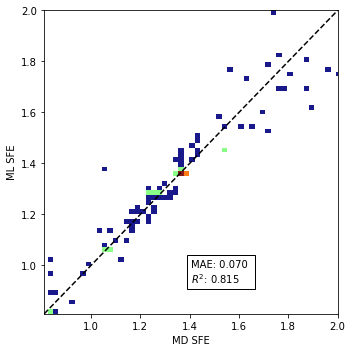

In [8]:
# 画出预测值和真实值的散点图
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots()

ax.hist2d(data_test_y, gbr_pridict, norm=matplotlib.colors.LogNorm(), bins=64, cmap='jet', alpha=0.9)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = sklearn.metrics.mean_absolute_error(data_test_y, gbr_pridict)
r2 = sklearn.metrics.r2_score(data_test_y, gbr_pridict)
ax.text(0.5, 0.1, 'MAE: {:.3f} \n$R^2$: {:.3f}'.format(mae, r2), transform=ax.transAxes, bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('MD SFE')
ax.set_ylabel('ML SFE')

fig.set_size_inches(5, 5)
fig.tight_layout()
fig.show()

In [9]:
# 保存模型
import joblib

joblib.dump(search_gbr, 'model_GBR.pkl')

# 加载模型
# search_gbr = joblib.load('model_GBR.pkl')

['model_GBR.pkl']